<a href="https://colab.research.google.com/github/pbackup12345/xlstm-ts/blob/main/notebooks/sp500_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Movement Prediction Using Wavelet-Based xLSTM-TS Model

**Notebook 1**: S&P 500 - Daily Close Prices

---


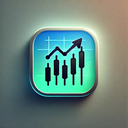

**Note**: Run with T4 GPU in Google Colab! (CUDA is required)

## Constants

**Dataset**: S&P 500 (US)

https://finance.yahoo.com/quote/%5EGSPC/

In [29]:
# Ticker (check in Yahoo Finance) and custom stock name
TICKER = 'SPY' # S&P 500 index
STOCK = 'S&P 500'

# Date range (YYYY-MM-DD) and frequency
START_DATE = '2000-01-01'
END_DATE = '2024-12-31'
FREQ = '1d' # daily frequency

FILE_NAME = 'sp500_daily' # custom file name

*   **Train**: 01/2000 - 12/2020
*   **Validation**: 01/2021 - 06/2022
*   **Test**: 07/2022 - 12/2023

In [30]:
# Train, validation, test split
TRAIN_END_DATE = '2022-12-31'
VAL_END_DATE = '2023-12-31'

## Requirements

In [31]:
repo_url = 'https://github.com/pbackup12345/xlstm-ts.git'

# Clone the repository
!git clone {repo_url}

Cloning into 'xlstm-ts'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 427 (delta 121), reused 61 (delta 57), pack-reused 252 (from 1)
Receiving objects: 100% (427/427), 17.63 MiB | 19.45 MiB/s, done.
Resolving deltas: 100% (239/239), done.


In [32]:
%cd xlstm-ts

/content/xlstm-ts/xlstm-ts


NOTE: It can take a few minutes to install all dependencies.

In [33]:
!pip install -r requirements.txt --quiet

In [34]:
# Add the src directory to the Python path
import sys
import os

# Get the path of the current working directory
current_dir = os.getcwd()

# Construct the path to the 'src' directory in the current folder
src_path = os.path.join(current_dir, 'src')

# Add the 'src' directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

In [35]:
from ml.utils.imports import *

### Optional: Retrieve MORE hourly data (API limitations apply)

(SKIP THIS STEP IF YOU DO NOT NEED HOURLY DATA MORE THAN 2 YEARS OLD)

**Where to find your Tiingo API Token?**

**Step 1: Create a Tiingo account if you have not already.**

You can do so by visit https://api.tiingo.com and clicking “Sign-up” in the top right corner.

**Step 2: Access the API Token Account Page.**

Visit https://api.tiingo.com/account/api/token to see your API Token and copy it below. Do not share it with anybody as this token will identify your usage with your account.

In [36]:
os.environ['TIINGO_API_KEY'] = '' # Add your Tiingo API key here

## Dataset

In [37]:
from ml.data.download import download_data
from ml.utils.visualisation import plot_data

### **Optional: Read local files**

If you want to read the given data from the experiment, UNCOMMENT this code snippet and COMMENT OUT the regular download to proceed.

(NOTE: The regular download will retrieve the exact same data by default, you can experiment with the constants at the top of the file to change it)

In [38]:
'''
# Read the CSV file and set the "Date" column as the index
file_path = os.path.join('data', 'datasets', FILE_NAME + '.csv')
df = pd.read_csv(file_path, header=0, index_col='Date')
# Convert the index to a datetime object
df.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
'''

'\n# Read the CSV file and set the "Date" column as the index\nfile_path = os.path.join(\'data\', \'datasets\', FILE_NAME + \'.csv\')\ndf = pd.read_csv(file_path, header=0, index_col=\'Date\')\n# Convert the index to a datetime object\ndf.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))\n'

### Download data

- **Tiingo**: If the frequency is hourly and the starting date is more than 2 years before, the Tiingo API will be used. You need to enter the API key to proceed (the steps are explained above). Note that restrictive API limitations apply.

- **Yahoo Finance**: In all other cases, Yahoo Finance will be used. There's no need to enter an API key to download data from it, and there are no API restrictions with responsible usage.

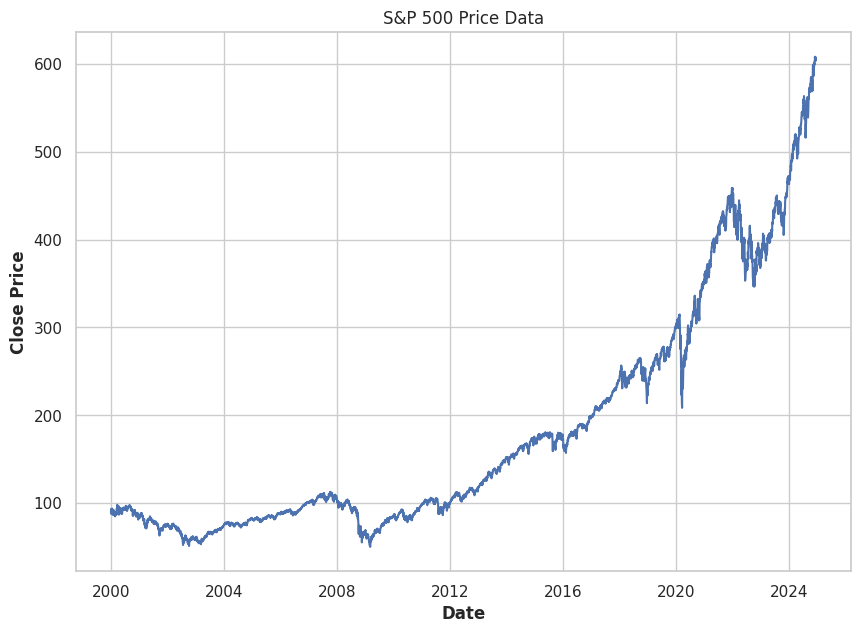

In [39]:
# Download the data
df = download_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, freq=FREQ)

# Plot the raw data
plot_data(df, STOCK)

## Preprocessing

### Wavelet denoising

Reference:
https://doi.org/10.1002/for.3071 (the idea of the wavelet denoising and some parameters are taken from this paper)

In [40]:
from ml.data.preprocessing import wavelet_denoising, plot_wavelet_denoising

Signal-to-Noise Ratio (SNR): 46.95 dB


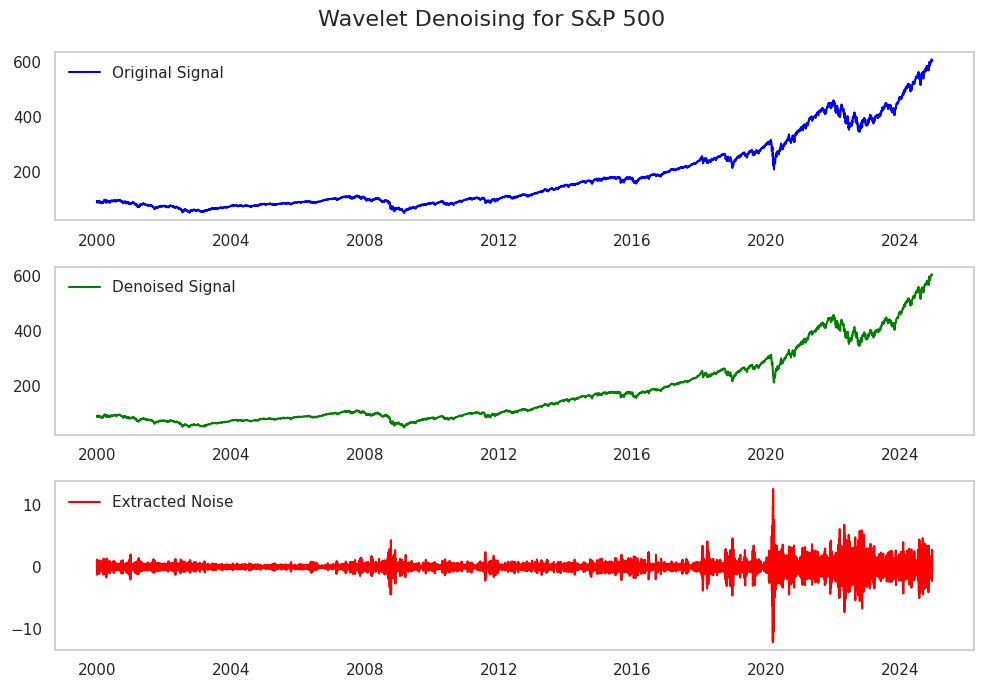

In [41]:
# Apply denoising

df['Close_denoised'] = wavelet_denoising(df['Close'])

df['Noise'] = df['Close'] - df['Close_denoised']

plot_wavelet_denoising(df, STOCK)

### Process dates

In [42]:
from ml.data.preprocessing import process_dates

In [43]:
# Convert the Date column to time zone-naive datetime
df = process_dates(df)

### Model-specific preprocessing

#### For the proposed model

##### Normalise data

In [44]:
from ml.models.xlstm_ts.preprocessing import normalise_data_xlstm

In [45]:
close_scaled, scaler = normalise_data_xlstm(df['Close'].values)
close_scaled_denoised, scaler_denoised = normalise_data_xlstm(df['Close_denoised'].values)


##### Create sequences

In [46]:
from ml.models.xlstm_ts.preprocessing import create_sequences

In [47]:
X, y, _ = create_sequences(close_scaled, df.index)
X_denoised, y_denoised, dates = create_sequences(close_scaled_denoised, df.index)

##### Train, Validation and Test split

In [48]:
from ml.models.xlstm_ts.preprocessing import split_train_val_test_xlstm

train X shape: torch.Size([5687, 100, 1])
train y shape: torch.Size([5687, 1])
val X shape: torch.Size([250, 100, 1])
val y shape: torch.Size([250, 1])
test X shape: torch.Size([240, 100, 1])
test y shape: torch.Size([240, 1])


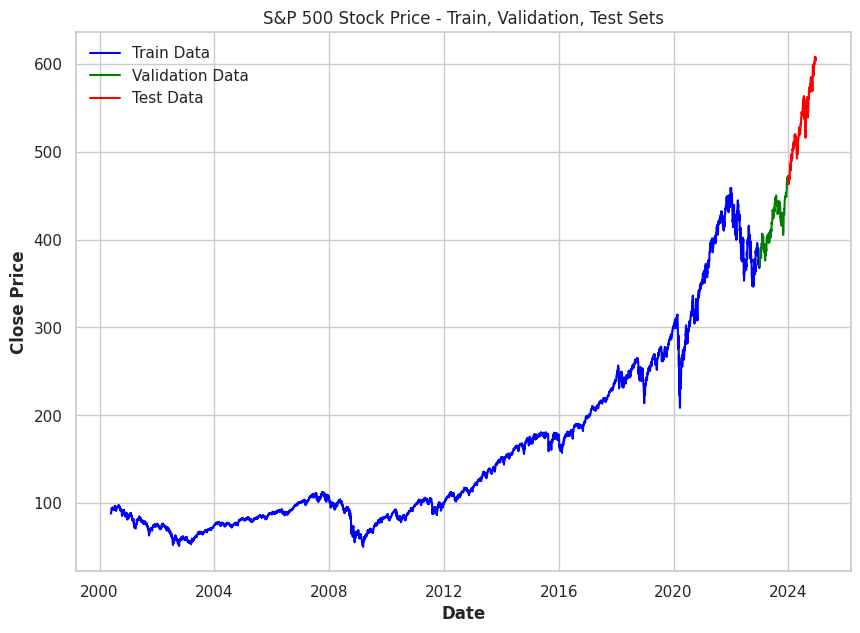

train X shape: torch.Size([5687, 100, 1])
train y shape: torch.Size([5687, 1])
val X shape: torch.Size([250, 100, 1])
val y shape: torch.Size([250, 1])
test X shape: torch.Size([240, 100, 1])
test y shape: torch.Size([240, 1])


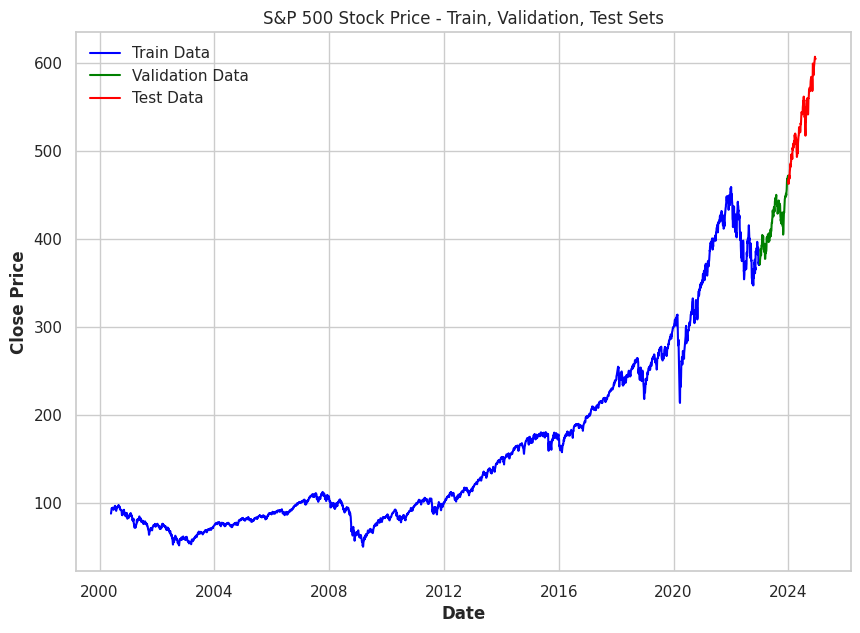

In [49]:
train_X, train_y, _, val_X, val_y, _, test_X, test_y, _ = split_train_val_test_xlstm(X, y, dates, TRAIN_END_DATE, VAL_END_DATE, scaler, STOCK)

train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, test_dates = split_train_val_test_xlstm(X_denoised, y_denoised, dates, TRAIN_END_DATE, VAL_END_DATE, scaler_denoised, STOCK)

## Models

In [50]:
from ml.models.shared.directional_prediction import *
from ml.models.shared.metrics import *
from ml.models.shared.visualisation import *
from ml.models.darts.darts_models import *
from ml.models.darts.training import *

In [51]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

### New proposed model: xLSTM-TS, a time series-specific implementation

**References:**

- xLSTM Paper (2024): https://doi.org/10.48550/arXiv.2405.04517

- Official code: https://github.com/NX-AI/xlstm

- Parameters for time series: https://github.com/smvorwerk/xlstm-cuda

#### Configuration

In [52]:
from ml.models.xlstm_ts.xlstm_ts_model import *
from ml.models.xlstm_ts.logic import *

In [53]:
plot_architecture_xlstm()

#### Training and evaluation

In [54]:
model_name = 'xLSTM-TS'

**Denoised**

Epoch [1/200], Loss: 0.00091129, Validation Loss: 0.00015151
Epoch [2/200], Loss: 0.00030148, Validation Loss: 0.00006392
Epoch [3/200], Loss: 0.00005314, Validation Loss: 0.00003954
Epoch [4/200], Loss: 0.00014773, Validation Loss: 0.00005133
Epoch [5/200], Loss: 0.00000952, Validation Loss: 0.00006212
Epoch [6/200], Loss: 0.00001458, Validation Loss: 0.00008182
Epoch [7/200], Loss: 0.00019406, Validation Loss: 0.00009440
Epoch [8/200], Loss: 0.00004973, Validation Loss: 0.00002741
Epoch [9/200], Loss: 0.00013353, Validation Loss: 0.00025489
Epoch [10/200], Loss: 0.00009720, Validation Loss: 0.00003486
Epoch [11/200], Loss: 0.00000851, Validation Loss: 0.00004108
Epoch [12/200], Loss: 0.00007228, Validation Loss: 0.00002882
Epoch [13/200], Loss: 0.00071888, Validation Loss: 0.00035719
Epoch [14/200], Loss: 0.00000938, Validation Loss: 0.00002539
Epoch [15/200], Loss: 0.00004144, Validation Loss: 0.00002569
Epoch [16/200], Loss: 0.00002360, Validation Loss: 0.00002235
Epoch [17/200], L

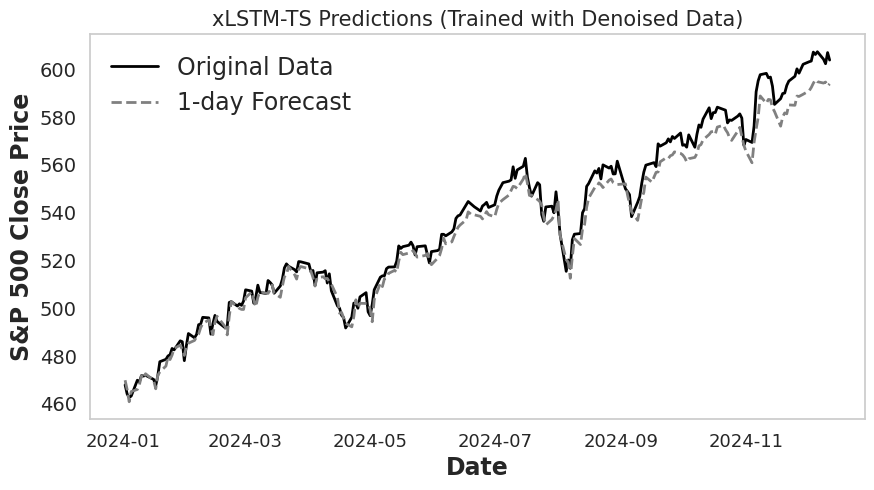

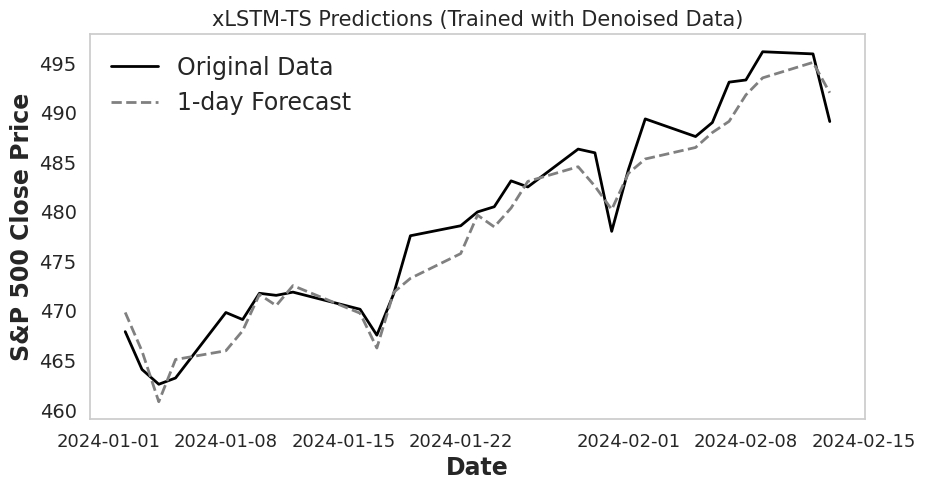

xLSTM-TS (Denoised) | Train Accuracy: 67.97%
xLSTM-TS (Denoised) | Validation Accuracy: 72.69%
xLSTM-TS (Denoised) | Test Accuracy: 66.11%
xLSTM-TS (Denoised) | Recall: 69.23%
xLSTM-TS (Denoised) | Precision (Rise): 72.79%
xLSTM-TS (Denoised) | Precision (Fall): 57.28%
xLSTM-TS (Denoised) | F1 Score: 70.97%


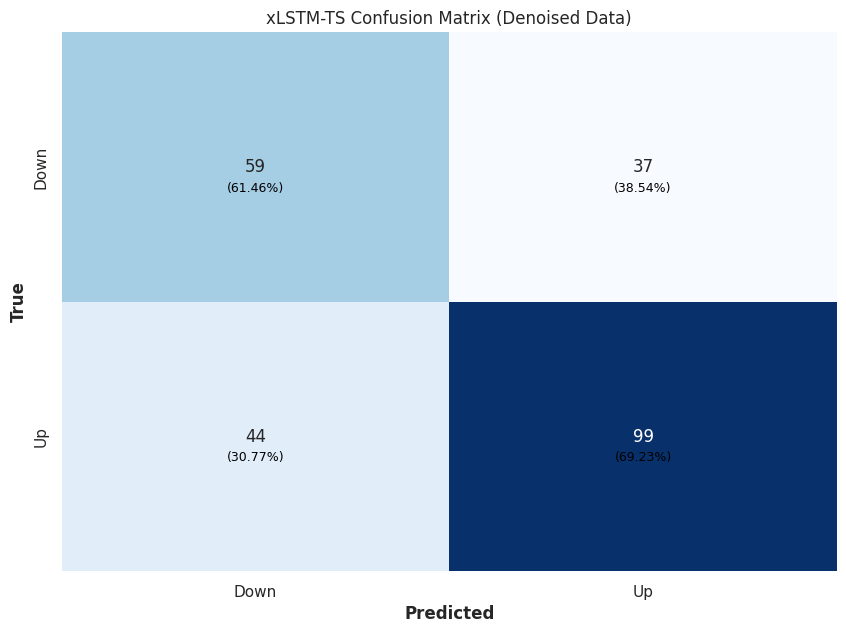

In [55]:
results_denoised_df, metrics_denoised = run_xlstm_ts(train_X_denoised, train_y_denoised, val_X_denoised, val_y_denoised, test_X_denoised, test_y_denoised, scaler_denoised, STOCK, 'Denoised', test_dates, train_y, val_y, test_y)

In [63]:
xlstm_stack, input_projection, output_projection = create_xlstm_model(150)

test_predictions = evaluate_model(xlstm_stack, input_projection, output_projection, test_X_denoised)

# Invert the normalisation for comparison
test_predictions = inverse_normalise_data_xlstm(test_predictions.squeeze(), scaler)
f = open('./res.csv',"w")



for idx in range(1,len(test_predictions)):
  if idx == 0:
    continue
  # Access test_dates using .iloc to get the value at the integer position idx
  print(pd.to_datetime(test_dates.values[idx]).strftime('%Y-%m-%d') + " " + ("up" if test_predictions[idx][0] - test_predictions[idx-1][0] > 0 else "down")+" "+str(test_predictions[idx][0]))
  f.write(pd.to_datetime(test_dates.values[idx]).strftime('%Y-%m-%d') + "\t" + ("up" if test_predictions[idx][0] - test_predictions[idx-1][0] > 0 else "down")+"\t"+str(test_predictions[idx][0] - test_predictions[idx-1][0])+"\n")
# If the original data is provided, use it for the evaluation

f.close()

2024-01-03 up -182.73618
2024-01-04 up -181.82474
2024-01-05 up -180.67673
2024-01-08 down -183.08896
2024-01-09 down -183.79626
2024-01-10 up -183.17351
2024-01-11 down -183.56023
2024-01-12 down -183.8823
2024-01-16 up -179.85199
2024-01-17 up -178.18135
2024-01-18 up -177.3577
2024-01-19 down -177.98563
2024-01-22 down -181.08005
2024-01-23 down -181.16812
2024-01-24 down -182.04735
2024-01-25 up -181.55019
2024-01-26 up -180.85046
2024-01-29 down -180.93059
2024-01-30 down -181.49261
2024-01-31 up -179.4814
2024-02-01 up -178.17732
2024-02-02 down -181.31854
2024-02-05 down -183.51172
2024-02-06 up -181.29005
2024-02-07 down -181.5145
2024-02-08 up -180.75894
2024-02-09 down -181.44041
2024-02-12 down -182.51822
2024-02-13 up -180.95287
2024-02-14 up -177.65018
2024-02-15 up -177.33073
2024-02-16 down -178.82947
2024-02-20 up -178.47635
2024-02-21 up -175.73294
2024-02-22 up -174.3262
2024-02-23 down -177.18071
2024-02-26 up -176.98253
2024-02-27 up -174.1409
2024-02-28 up -171.037

In [56]:
metrics_accumulator_denoised[model_name] = metrics_denoised